## Generate Test Data

In [46]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy
import scipy
import sklearn.cross_validation

n = 100

numpy.random.seed(0) # setting seed to keep data constant
x_noise = numpy.random.rand(n) * 0.05
numpy.random.seed(123456) # setting seed to keep data constant
y_noise = numpy.random.rand(n) * 7

x = scipy.linspace(0, 8, n)
x += x_noise

y = x * numpy.sin(x)
y += y_noise

x_train, x_test, y_train, y_test = sklearn.cross_validation.train_test_split(x, y, test_size=0.3)

## Using Math Helpers
### Plotting different model functions at different model complexities

Cost Function with respect to given parameters ($\Theta$): $$J(\Theta) = \frac{1}{m} \sum\limits_{i=1}^n (h_\Theta(x^i) - y^i)^2$$

In [71]:
def get_error(predicted, actual):
    diff = predicted - actual
    return numpy.mean(numpy.square(diff))


def get_error_from_params(x, y, params):
    predicted = numpy.polyval(params, x)
    return get_error(predicted, y)

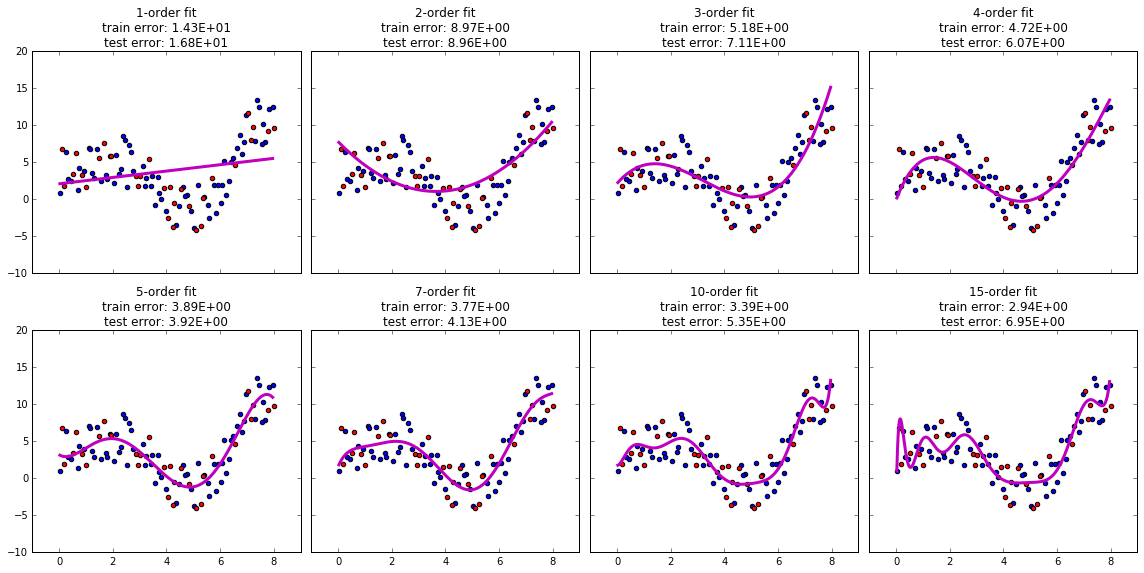

In [72]:
n_rows = 2
n_cols = 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, sharey=True, figsize=(16,8))
list_of_plot_pos = [(r,c) for r in range(n_rows) for c in range(n_cols)]

def add_plot_for_params(params):
    
    fx = scipy.linspace(numpy.min(x_train), numpy.max(x_train), 1000)
    fy = numpy.polyval(params, fx)
    
    train_error = get_error_from_params(x_train, y_train, params)
    test_error = get_error_from_params(x_test, y_test, params)
    
    (row,col) = list_of_plot_pos.pop(0)
    ax = axes[row, col]
    
    # ignoring constant with respect to polynomial order
    order = params.size - 1 
    ax.set_title('{0}-order fit\ntrain error: {1:.2E}\ntest error: {2:.2E}'.format(order, train_error, test_error))
    ax.scatter(x_train ,y_train)
    ax.scatter(x_test, y_test, c='r')
    
    # autoscale based only on the scatterplot
    # ax.autoscale(False) 
    ax.plot(fx,fy, linewidth=3, c='m')

for order in [1,2,3,4,5,7,10,15]:
    params = scipy.polyfit(x_train , y_train, order)
    add_plot_for_params(params)

plt.tight_layout()
plt.show()

### Plot model complexity effect on test and training error

order	training error	test error
0	1.53E+01	1.73E+01
1	1.43E+01	1.68E+01
2	8.97E+00	8.96E+00
3	5.18E+00	7.11E+00
4	4.72E+00	6.07E+00
5	3.89E+00	3.92E+00
6	3.87E+00	3.94E+00
7	3.77E+00	4.13E+00
8	3.77E+00	4.13E+00
9	3.60E+00	4.30E+00
10	3.39E+00	5.35E+00
11	3.38E+00	5.41E+00
12	3.19E+00	5.13E+00
13	3.03E+00	6.28E+00
14	2.95E+00	6.34E+00
15	2.94E+00	6.95E+00


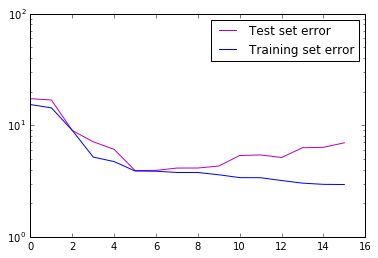

In [73]:
# TODO below

train_e = []
test_e = []
error_comparison_order_limit = 16
print('order\ttraining error\ttest error')
for n in range(error_comparison_order_limit):
    
    params = scipy.polyfit(x_train , y_train, n)
    fx = scipy.linspace(numpy.min(x_train), numpy.max(x_train), 1000)
    fy = numpy.polyval(params, fx)
    
    train_error = get_error_from_params(x_train, y_train, params)
    train_e.append(train_error)
    test_error = get_error_from_params(x_test, y_test, params) # TODO should be using a validation set here
    test_e.append(test_error)
    print('{0}\t{1:.2E}\t{2:.2E}'.format(n, train_error, test_error))
    
plt.semilogy(range(error_comparison_order_limit), test_e, c='m')
plt.semilogy(range(error_comparison_order_limit), train_e)
plt.legend(['Test set error', 'Training set error'])
plt.show()

## Using sklearn

order		test on training	kfold validation			true test
0		1.53E+01			1.58E+01				1.73E+01
1		1.43E+01			1.60E+01				1.68E+01
2		8.97E+00			9.82E+00				8.96E+00
3		5.18E+00			6.54E+00				7.11E+00
4		4.72E+00			5.98E+00				6.07E+00
5		3.89E+00			5.04E+00				3.92E+00
6		3.87E+00			6.23E+00				3.94E+00
7		3.77E+00			5.99E+00				4.13E+00
8		3.77E+00			9.38E+00				4.13E+00
9		3.60E+00			1.01E+01				4.30E+00
10		3.39E+00			2.08E+01				5.35E+00
11		3.38E+00			4.68E+01				5.41E+00
12		3.19E+00			1.51E+02				5.13E+00
13		3.03E+00			1.05E+02				6.28E+00
14		3.18E+00			1.27E+02				5.99E+00
15		3.28E+00			2.26E+02				5.77E+00
best order per validation testing: 5


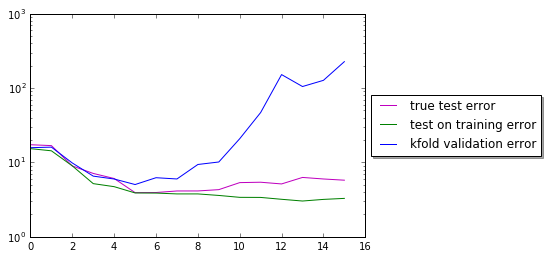

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def get_model(xs, ys, n_poly):
    model = make_pipeline(PolynomialFeatures(n_poly), LinearRegression())
    model.fit(xs.reshape(xs.size, 1), ys)
    return model


def get_predictions(model, xs):
    return model.predict(xs.reshape(xs.size, 1))
    
    
def get_poly_error(train__x, train__y, test__x, test__y, n_poly):
    model = get_model(train__x, train__y, n_poly)
    predictions = get_predictions(model, test__x)
    return get_error(predictions, test__y)
    
    
max_poly_order = 16
poly_orders = range(max_poly_order)

kf = KFold(x_train.size, shuffle=True, n_folds=3)
kfold_validation_error_list = []
for n_poly in poly_orders:
    errors = []
    for train_index, test_index in kf:
        e = get_poly_error(x_train[train_index], 
                           y_train[train_index], 
                           x_train[test_index], 
                           y_train[test_index], 
                           n_poly)
        errors.append(e)
    diff = numpy.mean(errors)
    kfold_validation_error_list.append(diff)
    
true_test_error_list = [get_poly_error(x_train, 
                                  y_train, 
                                  x_test, 
                                  y_test, 
                                  o) for o in poly_orders]
test_on_training_error_list = [get_poly_error(x_train, 
                                              y_train, 
                                              x_train, 
                                              y_train, 
                                              o) for o in poly_orders]

print('order\t\ttest on training\tkfold validation\t\t\ttrue test')
for o in poly_orders:
    print('{0}\t\t{1:.2E}\t\t\t{2:.2E}\t\t\t\t{3:.2E}'.format(o, 
                                                    test_on_training_error_list[o], 
                                                    kfold_validation_error_list[o], 
                                                    true_test_error_list[o]))

best_order = kfold_validation_error_list.index(min(kfold_validation_error_list))
test_error = get_poly_error(x_train, y_train, x_test, y_test, best_order) 
print('best order per validation testing: {0}'.format(best_order))


plt.semilogy(poly_orders, true_test_error_list, c='m', label='true test error')
plt.semilogy(poly_orders, test_on_training_error_list, c='g', label='test on training error')
plt.semilogy(poly_orders, kfold_validation_error_list, label='kfold validation error')
plt.legend(loc='center left', 
           bbox_to_anchor=(1, 0.5), 
           shadow=True)
plt.show()

In [6]:
# TODO use ridge or lasso regresssion
# TODO use panda dataframe
# TODO add math formulas using latex
# TODO use one of scipy's built in cross-validation capabilities